# Tax Credit Analysis vs Jobs

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
)

DEBUG:jupyter_black:config: {'line_length': 79}


<IPython.core.display.Javascript object>

In [3]:
# Import packages
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt

import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import median_test, shapiro

from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate

In [4]:
from src.linear_analysis import (
    bootstrap_poly_quantile_regression_analysis,
    run_quantile_regression,
)


In [5]:
k = 5
poly_order_max = 5

In [6]:
JOBS_ESTIMATE = 9

In [7]:
# Prep demographic data
CSV_DIR = os.path.join("..", "csv_data")
FEATURE_DATA_PATH = os.path.join(CSV_DIR, "feature_data")
TAX_CREDIT_DATA_PATH = os.path.join(CSV_DIR, "tax_credit_data")
FIGURES_DIR = os.path.join("..", "figures")


demographics_colors = ["#1b9e77", "#7570b3", "#d95f02"]
pvi_colors = ["#e41a1c", "#984ea3", "#377eb8"]  # red, purple, blue

In [8]:
import matplotlib

matplotlib.rcParams.update({"font.size": 14})

In [9]:
warnings.filterwarnings("ignore")

## Tax Credit Data

### Read in and prep the tax credit data

In [10]:
def prep_county_data(filepath, year):

    tax_credit_df = pd.read_csv(
        filepath,
        delimiter=",",
    )

    tax_credit_df = tax_credit_df.rename(
        columns={
            "STATE": "state_name",
            "STATEFIPS": "state",
            "COUNTYFIPS": "county",
        }
    )

    tax_credit_df = tax_credit_df[(tax_credit_df["county"] != 0)]
    tax_credit_df["state"] = tax_credit_df["state"].astype(str).str.zfill(2)
    tax_credit_df["county"] = tax_credit_df["county"].astype(str).str.zfill(3)
    tax_credit_df["geoid"] = tax_credit_df["state"].astype(
        str
    ) + tax_credit_df["county"].astype(str)

    tax_credit_df = tax_credit_df.rename(
        columns={
            "N07260": "Number of returns",
            "A07260": "Amount of returns",
            "N18500": "Number of real estate taxes",
            "N1": "Total Returns",
        }
    )

    # Filter down to only columns we need
    tax_credit_df = tax_credit_df[
        [
            "state",
            "geoid",
            #             "agi_stub",
            "Total Returns",
            "Number of returns",
            "Amount of returns",
            "Number of real estate taxes",
        ]
    ]

    # Add variables with varying normalization techniques
    tax_credit_df["year"] = year

    #     tax_credit_df["value_returns"] = (
    #         tax_credit_df["Amount of returns"] / tax_credit_df["Number of returns"]
    #     ) * 1000
    tax_credit_df["value_returns"] = 0
    tax_credit_df.loc[
        tax_credit_df["Number of returns"] >= 1, "value_returns"
    ] = (
        tax_credit_df["Amount of returns"].astype(float)
        / tax_credit_df["Number of returns"].astype(float)
    ) * 1000

    # Calculate participation
    #     tax_credit_df["percent_returns"] = (
    #         tax_credit_df["Number of returns"] / tax_credit_df["Total Returns"]
    #     ) * 100
    tax_credit_df["percent_returns"] = 0
    tax_credit_df.loc[
        tax_credit_df["Number of returns"] >= 1, "percent_returns"
    ] = (
        tax_credit_df["Number of returns"].astype(float)
        / tax_credit_df["Total Returns"].astype(float)
    ) * 100

    #     tax_credit_df["percent_homeowners"] = (
    #         tax_credit_df["Number of real estate taxes"]
    #         / tax_credit_df["Total Returns"]
    #     )
    tax_credit_df["percent_homeowners"] = 0
    tax_credit_df.loc[
        tax_credit_df["Number of real estate taxes"] >= 1, "percent_homeowners"
    ] = (
        tax_credit_df["Number of real estate taxes"]
        / tax_credit_df["Total Returns"]
    )

    return tax_credit_df

In [11]:
_2016 = prep_county_data(
    os.path.join(CSV_DIR, "county_no_agi", "16incyallnoagi.csv"),
    2016,
)
_2017 = prep_county_data(
    os.path.join(CSV_DIR, "county_no_agi", "17incyallnoagi.csv"),
    2017,
)
_2018 = prep_county_data(
    os.path.join(CSV_DIR, "county_no_agi", "18incyallnoagi.csv"),
    2018,
)
_2019 = prep_county_data(
    os.path.join(CSV_DIR, "county_no_agi", "19incyallnoagi.csv"),
    2019,
)
_2020 = prep_county_data(
    os.path.join(CSV_DIR, "county_no_agi", "20incyallnoagi.csv"),
    2020,
)

In [12]:
_2016

,state,geoid,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,percent_homeowners
1,01,01001,24090,400,178,5080,2016,445.000000,1.660440,0.210876
2,01,01003,95900,1550,914,22530,2016,589.677419,1.616267,0.234932
3,01,01005,9210,130,55,1360,2016,423.076923,1.411509,0.147666
4,01,01007,7940,150,71,1140,2016,473.333333,1.889169,0.143577
5,01,01009,22110,420,195,3980,2016,464.285714,1.899593,0.180009
...,...,...,...,...,...,...,...,...,...,...
3187,56,56037,19570,350,126,3950,2016,360.000000,1.788452,0.201840
3188,56,56039,14220,110,305,3850,2016,2772.727273,0.773558,0.270745
3189,56,56041,9030,150,104,1840,2016,693.333333,1.661130,0.203765
3190,56,56043,3670,60,14,500,2016,233.333333,1.634877,0.136240


In [13]:
# join all years together
frames = [
    _2016,
    _2017,
    _2018,
    _2019,
    _2020,
]

all_years = pd.concat(frames)

In [14]:
all_years.describe()

,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,percent_homeowners
count,1.570700e+04,15707.000000,15707.000000,1.570700e+04,15707.000000,15707.000000,15707.000000,15707.000000
mean,4.923813e+04,585.349844,873.579551,7.704378e+03,2018.000191,907.180301,0.909466,0.101701
std,1.594216e+05,2045.291785,4584.009491,3.049650e+04,1.414281,984.242023,0.752944,0.090406
min,4.000000e+01,0.000000,0.000000,0.000000e+00,2016.000000,0.000000,0.000000,0.000000
25%,4.670000e+03,30.000000,11.000000,2.100000e+02,2017.000000,283.333333,0.245260,0.031496
50%,1.143000e+04,90.000000,81.000000,7.800000e+02,2018.000000,608.333333,0.860456,0.069452
75%,3.063000e+04,330.000000,329.000000,3.305000e+03,2019.000000,1222.222222,1.357466,0.150282
max,5.028630e+06,49270.000000,150541.000000,1.104490e+06,2020.000000,9450.000000,9.717868,0.526936


## Updated Demographic data

In [15]:
demographics_2020 = pd.read_csv(
    os.path.join(
        CSV_DIR,
        "county_no_agi",
        "ACSST5Y2020.S2502_2023-10-03T153322",
        "ACSST5Y2020.S2502-Data.csv",
    ),
)
demographics_2020 = demographics_2020.rename(
    columns={
        "Estimate Occupied housing units Occupied housing units": "total_occupied_units",
        "Estimate Owner-occupied housing units Occupied housing units": "total_owner_occupied_occupied_units",
        "Estimate Occupied housing units Occupied housing units RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER White alone, not Hispanic or Latino": "total_white_alone_occupied_units",
    }
)
demographics_2020["geoid"] = demographics_2020["Geography"].str[-5:]
demographics_2020 = demographics_2020[
    [
        "geoid",
        "total_occupied_units",
        "total_owner_occupied_occupied_units",
        "total_white_alone_occupied_units",
    ]
]
demographics_2020["percent_owner_occupied"] = demographics_2020[
    "total_owner_occupied_occupied_units"
].astype(float) / demographics_2020["total_occupied_units"].astype(float)
demographics_2020["percent_white_alone"] = demographics_2020[
    "total_white_alone_occupied_units"
].astype(float) / demographics_2020["total_occupied_units"].astype(float)
demographics_2020

,geoid,total_occupied_units,total_owner_occupied_occupied_units,total_white_alone_occupied_units,percent_owner_occupied,percent_white_alone
0,01001,21559,16088,16512,0.746231,0.765898
1,01003,84047,64716,72576,0.769998,0.863517
2,01005,9322,5775,4702,0.619502,0.504398
3,01007,7259,5428,5742,0.747761,0.791018
4,01009,21205,16132,19193,0.760764,0.905117
...,...,...,...,...,...,...
3216,72145,19343,14974,201,0.774130,0.010391
3217,72147,2405,1690,138,0.702703,0.057380
3218,72149,7932,5684,0,0.716591,0.000000
3219,72151,11687,8387,22,0.717635,0.001882


In [16]:
income_2020 = pd.read_csv(
    os.path.join(
        CSV_DIR,
        "ACSST5Y2020.S1901_2023-10-04T133502",
        "ACSST5Y2020.S1901-Data.csv",
    ),
)
income_2020 = income_2020.rename(
    columns={"Estimate Households Median income (dollars)": "median_income"}
)
income_2020["geoid"] = income_2020["Geography"].str[-5:]
income_2020 = income_2020[["geoid", "median_income"]]
income_2020

,geoid,median_income
0,01001,57982
1,01003,61756
2,01005,34990
3,01007,51721
4,01009,48922
...,...,...
3216,72145,20126
3217,72147,14040
3218,72149,19355
3219,72151,16828


In [17]:
income_2020 = income_2020.replace("-", np.nan)
income_2020 = income_2020.dropna()

income_2020["median_income"] = income_2020["median_income"].astype(float)
income_2020["log_median_income"] = np.log(income_2020["median_income"])
income_2020

,geoid,median_income,log_median_income
0,01001,57982.0,10.967888
1,01003,61756.0,11.030946
2,01005,34990.0,10.462818
3,01007,51721.0,10.853619
4,01009,48922.0,10.797982
...,...,...,...
3216,72145,20126.0,9.909768
3217,72147,14040.0,9.549666
3218,72149,19355.0,9.870706
3219,72151,16828.0,9.730799


In [18]:
# Stackoverflow article for reference: https://stackoverflow.com/questions/56441190/zero-padding-pandas-column
# all_years["geoid"] = all_years["zipcode"].astype(str).str.pad(5, fillchar="0")

## Combine county-level tax credits with jobs estimates

In [19]:
jobs_demographics_df = pd.read_csv(
    os.path.join(CSV_DIR, f"jobs_with_demographics_{JOBS_ESTIMATE}.csv")
)
jobs_demographics_df["geoid"] = (
    jobs_demographics_df["County"].astype(str).str.zfill(5)
)
jobs_demographics_df.drop(
    [
        "total_individuals",
        "white",
        "percent_white",
        "percent_owner_occupied",
        "median_income",
    ],
    axis=1,
    inplace=True,
)

In [20]:
jobs_demographics_df.columns

Index(['County', 'Solar', 'Wind', 'Hydro', 'renewable_jobs',
       'ENERGY STAR & Efficient Lighting', 'Traditional HVAC',
       'High Efficiency HVAC & Renewable H&C',
       'Advanced Materials & Insulation', 'Other EE', 'ee_jobs', 'total_jobs',
       'year', 'Low-Impact Hydroelectric', 'clean_jobs',
       'percent_jobs_renewables', 'percent_jobs_ee', 'percent_jobs_clean',
       'geoid'],
      dtype='object')

## Merging updated jobs with new demographic data

In [21]:
jobs_updated_demographics_df = pd.merge(
    jobs_demographics_df, demographics_2020, on="geoid"
)
jobs_updated_demographics_df = pd.merge(
    jobs_updated_demographics_df, income_2020, on="geoid"
)
jobs_updated_demographics_df

,County,Solar,Wind,Hydro,renewable_jobs,ENERGY STAR & Efficient Lighting,Traditional HVAC,High Efficiency HVAC & Renewable H&C,Advanced Materials & Insulation,Other EE,...,percent_jobs_ee,percent_jobs_clean,geoid,total_occupied_units,total_owner_occupied_occupied_units,total_white_alone_occupied_units,percent_owner_occupied,percent_white_alone,median_income,log_median_income
0,2013,9,0,0,9,9,0,9,9,9,...,0.014559,0.018198,02013,988,607,155,0.614372,0.156883,75833.0,11.236289
1,2013,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,02013,988,607,155,0.614372,0.156883,75833.0,11.236289
2,2013,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,02013,988,607,155,0.614372,0.156883,75833.0,11.236289
3,2013,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,02013,988,607,155,0.614372,0.156883,75833.0,11.236289
4,2013,9,0,0,9,9,0,9,9,9,...,0.015721,0.019651,02013,988,607,155,0.614372,0.156883,75833.0,11.236289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,56045,2,0,0,2,19,14,6,2,4,...,0.019832,0.020713,56045,2882,2419,2702,0.839348,0.937543,53333.0,10.884311
21963,56045,1,0,0,1,19,14,7,2,4,...,0.019616,0.020043,56045,2882,2419,2702,0.839348,0.937543,53333.0,10.884311
21964,56045,9,9,9,27,18,13,9,9,9,...,0.025537,0.037424,56045,2882,2419,2702,0.839348,0.937543,53333.0,10.884311
21965,56045,9,9,9,27,18,13,9,9,9,...,0.025325,0.037114,56045,2882,2419,2702,0.839348,0.937543,53333.0,10.884311


### Filter down to columns we need for easier merge

In [22]:
clean_jobs = jobs_updated_demographics_df[
    [
        "geoid",
        "year",
        "clean_jobs",
        "percent_jobs_clean",
        "total_owner_occupied_occupied_units",
        "percent_owner_occupied",
        "total_white_alone_occupied_units",
        "percent_white_alone",
        "median_income",
        "log_median_income",
    ]
]
clean_jobs

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289
1,02013,2017,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289
2,02013,2018,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289
3,02013,2019,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289
4,02013,2020,45,0.019651,607,0.614372,155,0.156883,75833.0,11.236289
...,...,...,...,...,...,...,...,...,...,...
21962,56045,2018,47,0.020713,2419,0.839348,2702,0.937543,53333.0,10.884311
21963,56045,2019,47,0.020043,2419,0.839348,2702,0.937543,53333.0,10.884311
21964,56045,2020,85,0.037424,2419,0.839348,2702,0.937543,53333.0,10.884311
21965,56045,2021,85,0.037114,2419,0.839348,2702,0.937543,53333.0,10.884311


In [23]:
tax_credit_participation = all_years[
    ["geoid", "year", "Number of returns", "percent_returns"]
]
tax_credit_participation

,geoid,year,Number of returns,percent_returns
1,01001,2016,400.0,1.660440
2,01003,2016,1550.0,1.616267
3,01005,2016,130.0,1.411509
4,01007,2016,150.0,1.889169
5,01009,2016,420.0,1.899593
...,...,...,...,...
3188,56037,2020,140.0,0.705290
3189,56039,2020,60.0,0.396563
3190,56041,2020,80.0,0.841220
3191,56043,2020,0.0,0.000000


In [24]:
jobs_vs_credits_all = pd.merge(
    clean_jobs, tax_credit_participation, how="outer"
)
jobs_vs_credits_all

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,Number of returns,percent_returns
0,02013,2016,45.0,0.018198,607.0,0.614372,155.0,0.156883,75833.0,11.236289,0.0,0.0
1,02013,2017,0.0,0.000000,607.0,0.614372,155.0,0.156883,75833.0,11.236289,0.0,0.0
2,02013,2018,0.0,0.000000,607.0,0.614372,155.0,0.156883,75833.0,11.236289,0.0,0.0
3,02013,2019,0.0,0.000000,607.0,0.614372,155.0,0.156883,75833.0,11.236289,0.0,0.0
4,02013,2020,45.0,0.019651,607.0,0.614372,155.0,0.156883,75833.0,11.236289,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21979,48243,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
21980,48263,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
21981,02063,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
21982,02066,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [25]:
jobs_vs_credits = pd.merge(clean_jobs, tax_credit_participation, how="inner")
jobs_vs_credits

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,Number of returns,percent_returns
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000
1,02013,2017,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000
2,02013,2018,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000
3,02013,2019,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000
4,02013,2020,45,0.019651,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
15685,56045,2016,87,0.037573,2419,0.839348,2702,0.937543,53333.0,10.884311,50.0,1.592357
15686,56045,2017,47,0.021131,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000
15687,56045,2018,47,0.020713,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000
15688,56045,2019,47,0.020043,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000


### Simple scatter plots

In [26]:
# Colors for plotting all curves on one plot


colors = [
    "#8c510a",
    "#bf812d",
    "#dfc27d",
    "#80cdc1",
    "#35978f",
    "#01665e",
]

colors4 = [
    "#8c510a",
    "#bf812d",
    "#35978f",
    "#01665e",
]

## Segmenting by demographic features

In [27]:
agi_thresholds = [0, 25000, 50000, 75000, 100000, 200000, np.inf]
agi_classes = [1, 2, 3, 4, 5, 6]

jobs_vs_credits["agi_by_median_income"] = pd.cut(
    jobs_vs_credits["median_income"], agi_thresholds, labels=agi_classes
)

In [28]:
jobs_vs_credits

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,Number of returns,percent_returns,agi_by_median_income
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4
1,02013,2017,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4
2,02013,2018,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4
3,02013,2019,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4
4,02013,2020,45,0.019651,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,56045,2016,87,0.037573,2419,0.839348,2702,0.937543,53333.0,10.884311,50.0,1.592357,3
15686,56045,2017,47,0.021131,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3
15687,56045,2018,47,0.020713,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3
15688,56045,2019,47,0.020043,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3


In [29]:
jobs_vs_credits["percent_white_alone_quartiles"] = pd.qcut(
    jobs_vs_credits["percent_white_alone"], 4, labels=False
)
jobs_vs_credits.sort_values(by="percent_white_alone_quartiles")

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,Number of returns,percent_returns,agi_by_median_income,percent_white_alone_quartiles
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0
3398,16063,2019,17,0.009973,1250,0.692905,1257,0.696785,52363.0,10.865956,0.0,0.000000,3,0
3399,16063,2020,72,0.043239,1250,0.692905,1257,0.696785,52363.0,10.865956,0.0,0.000000,3,0
11869,46031,2017,10,0.011804,670,0.556017,484,0.401660,36705.0,10.510668,0.0,0.000000,2,0
11868,46031,2016,63,0.074023,670,0.556017,484,0.401660,36705.0,10.510668,0.0,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10384,39073,2017,103,0.015223,8950,0.776034,11188,0.970086,54774.0,10.910971,60.0,0.479233,3,3
10383,39073,2016,118,0.017291,8950,0.776034,11188,0.970086,54774.0,10.910971,220.0,1.768489,3,3
10382,39071,2020,107,0.010465,11732,0.700543,16195,0.967039,47973.0,10.778394,200.0,1.003512,2,3
10391,39075,2019,545,0.027379,9612,0.778237,12230,0.990203,64453.0,11.073692,430.0,2.388889,3,3


In [30]:
jobs_vs_credits["percent_owner_occupied_quartiles"] = pd.qcut(
    jobs_vs_credits["percent_owner_occupied"], 4, labels=False
)

jobs_vs_credits.sort_values(by="percent_owner_occupied_quartiles")

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,Number of returns,percent_returns,agi_by_median_income,percent_white_alone_quartiles,percent_owner_occupied_quartiles
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0
14075,51520,2016,118,0.012423,4600,0.614809,6823,0.911922,39679.0,10.588577,90.0,1.260504,2,2,0
14076,51520,2017,105,0.011558,4600,0.614809,6823,0.911922,39679.0,10.588577,30.0,0.424929,2,2,0
14077,51520,2018,104,0.011451,4600,0.614809,6823,0.911922,39679.0,10.588577,0.0,0.000000,2,2,0
14078,51520,2019,107,0.011845,4600,0.614809,6823,0.911922,39679.0,10.588577,20.0,0.274725,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7617,28019,2018,4,0.001804,2715,0.809723,2247,0.670146,36648.0,10.509114,50.0,1.506024,2,0,3
7616,28019,2017,6,0.002850,2715,0.809723,2247,0.670146,36648.0,10.509114,20.0,0.602410,2,0,3
7615,28019,2016,110,0.051248,2715,0.809723,2247,0.670146,36648.0,10.509114,70.0,2.160494,2,0,3
7629,28023,2020,72,0.026082,5322,0.851111,3944,0.630737,38631.0,10.561810,80.0,1.146132,2,0,3


In [31]:
jobs_vs_credits["median_income_quartiles"] = pd.qcut(
    jobs_vs_credits["median_income"], 4, labels=False
)

jobs_vs_credits.sort_values(by="median_income_quartiles")

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,Number of returns,percent_returns,agi_by_median_income,percent_white_alone_quartiles,percent_owner_occupied_quartiles,median_income_quartiles
7598,28011,2019,209,0.019254,6784,0.560013,4001,0.330279,32412.0,10.386284,140.0,1.063022,2,0,0,0
3298,16023,2019,12,0.001438,762,0.788820,934,0.966874,37404.0,10.529533,0.0,0.000000,2,3,3,0
3297,16023,2018,11,0.001378,762,0.788820,934,0.966874,37404.0,10.529533,0.0,0.000000,2,3,3,0
3296,16023,2017,11,0.001409,762,0.788820,934,0.966874,37404.0,10.529533,0.0,0.000000,2,3,3,0
3295,16023,2016,72,0.009428,762,0.788820,934,0.966874,37404.0,10.529533,0.0,0.000000,2,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12829,48091,2017,996,0.018329,40865,0.748635,40661,0.744898,80781.0,11.299497,720.0,1.014656,4,1,2,3
12830,48091,2018,1015,0.017836,40865,0.748635,40661,0.744898,80781.0,11.299497,360.0,0.480962,4,1,2,3
12831,48091,2019,1050,0.017646,40865,0.748635,40661,0.744898,80781.0,11.299497,890.0,1.109172,4,1,2,3
8331,37029,2017,25,0.019045,3010,0.769427,3071,0.785020,63834.0,11.064041,50.0,1.082251,3,1,2,3


In [32]:
jobs_vs_credits = jobs_vs_credits.rename(
    {"Number of returns": "num_returns"}, axis=1
)
jobs_vs_credits

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,num_returns,percent_returns,agi_by_median_income,percent_white_alone_quartiles,percent_owner_occupied_quartiles,median_income_quartiles
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3
1,02013,2017,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3
2,02013,2018,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3
3,02013,2019,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3
4,02013,2020,45,0.019651,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,56045,2016,87,0.037573,2419,0.839348,2702,0.937543,53333.0,10.884311,50.0,1.592357,3,2,3,2
15686,56045,2017,47,0.021131,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3,2,3,2
15687,56045,2018,47,0.020713,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3,2,3,2
15688,56045,2019,47,0.020043,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3,2,3,2


## Population density

In [33]:
county_urban_vs_rural_df = pd.read_excel("~/Downloads/2020_UA_COUNTY.xlsx")
county_urban_vs_rural_df

,STATE,COUNTY,STATE_NAME,COUNTY_NAME,POP_COU,HOU_COU,ALAND_COU,ALAND_Mi²_COU,POPDEN_COU,HOUDEN_COU,...,POP_RUR,POPPCT_RUR,HOU_RUR,HOUPCT_RUR,ALAND_RUR,ALAND_Mi²_RUR,ALAND_PCT_RUR,POPDEN_RUR,HOUDEN_RUR,RURALBLOCKS
0,1,1,Alabama,Autauga,58805,24350,1539634184,594.452758,98.922916,40.962044,...,23920,0.406768,9991,0.410308,1483727020,572.867002,0.963688,41.754892,17.440348,991
1,1,3,Alabama,Baldwin,231767,124148,4117656199,1589.827058,145.781265,78.088997,...,87113,0.375865,40740,0.328157,3762600021,1452.739868,0.913772,59.964624,28.043562,3181
2,1,5,Alabama,Barbour,25223,11618,2292160149,885.003034,28.500467,13.127639,...,16627,0.659200,7538,0.648821,2276027730,878.774307,0.992962,18.920672,8.577857,1011
3,1,7,Alabama,Bibb,22293,9002,1612188717,622.466064,35.814001,14.461833,...,22293,1.000000,9002,1.000000,1612188717,622.466064,1.000000,35.814001,14.461833,1090
4,1,9,Alabama,Blount,59134,24622,1670259090,644.887035,91.696680,38.180330,...,53510,0.904894,22337,0.907197,1658933117,640.514076,0.993219,83.542270,34.873551,2207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,72,151,Puerto Rico,Yabucoa,30426,14283,143005188,55.214303,551.052867,258.682972,...,5501,0.180799,2424,0.169712,82813495,31.974290,0.579094,172.044475,75.810908,87
3230,72,153,Puerto Rico,Yauco,34172,16599,175371930,67.711102,504.673516,245.144437,...,6088,0.178158,2856,0.172059,140103916,54.094122,0.798896,112.544576,52.796864,173
3231,78,10,US Virgin Islands,St. Croix,41004,25470,215914981,83.364774,491.862425,305.524729,...,2632,0.064189,1757,0.068983,126886794,48.990991,0.587670,53.724163,35.863737,439
3232,78,20,US Virgin Islands,St. John,3881,3645,50998053,19.690348,197.101643,185.116076,...,917,0.236279,964,0.264472,42952078,16.583797,0.842230,55.294935,58.129027,264


In [34]:
county_urban_vs_rural_filtered_df = county_urban_vs_rural_df.copy()

In [35]:
county_urban_vs_rural_filtered_df["state_id"] = (
    county_urban_vs_rural_filtered_df["STATE"].astype(str).str.zfill(2)
)
county_urban_vs_rural_filtered_df["county_id"] = (
    county_urban_vs_rural_filtered_df["COUNTY"].astype(str).str.zfill(3)
)
county_urban_vs_rural_filtered_df["geoid"] = county_urban_vs_rural_filtered_df[
    "state_id"
].astype(
    str
) + county_urban_vs_rural_filtered_df[  # .str
    "county_id"
].astype(
    str
)  # .str

In [36]:
county_urban_vs_rural_filtered_df

,STATE,COUNTY,STATE_NAME,COUNTY_NAME,POP_COU,HOU_COU,ALAND_COU,ALAND_Mi²_COU,POPDEN_COU,HOUDEN_COU,...,HOUPCT_RUR,ALAND_RUR,ALAND_Mi²_RUR,ALAND_PCT_RUR,POPDEN_RUR,HOUDEN_RUR,RURALBLOCKS,state_id,county_id,geoid
0,1,1,Alabama,Autauga,58805,24350,1539634184,594.452758,98.922916,40.962044,...,0.410308,1483727020,572.867002,0.963688,41.754892,17.440348,991,01,001,01001
1,1,3,Alabama,Baldwin,231767,124148,4117656199,1589.827058,145.781265,78.088997,...,0.328157,3762600021,1452.739868,0.913772,59.964624,28.043562,3181,01,003,01003
2,1,5,Alabama,Barbour,25223,11618,2292160149,885.003034,28.500467,13.127639,...,0.648821,2276027730,878.774307,0.992962,18.920672,8.577857,1011,01,005,01005
3,1,7,Alabama,Bibb,22293,9002,1612188717,622.466064,35.814001,14.461833,...,1.000000,1612188717,622.466064,1.000000,35.814001,14.461833,1090,01,007,01007
4,1,9,Alabama,Blount,59134,24622,1670259090,644.887035,91.696680,38.180330,...,0.907197,1658933117,640.514076,0.993219,83.542270,34.873551,2207,01,009,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,72,151,Puerto Rico,Yabucoa,30426,14283,143005188,55.214303,551.052867,258.682972,...,0.169712,82813495,31.974290,0.579094,172.044475,75.810908,87,72,151,72151
3230,72,153,Puerto Rico,Yauco,34172,16599,175371930,67.711102,504.673516,245.144437,...,0.172059,140103916,54.094122,0.798896,112.544576,52.796864,173,72,153,72153
3231,78,10,US Virgin Islands,St. Croix,41004,25470,215914981,83.364774,491.862425,305.524729,...,0.068983,126886794,48.990991,0.587670,53.724163,35.863737,439,78,010,78010
3232,78,20,US Virgin Islands,St. John,3881,3645,50998053,19.690348,197.101643,185.116076,...,0.264472,42952078,16.583797,0.842230,55.294935,58.129027,264,78,020,78020


In [37]:
county_urban_vs_rural_filtered_df = county_urban_vs_rural_filtered_df[
    ["geoid", "POP_COU", "POP_URB", "POPPCT_URB", "POP_RUR", "POPPCT_RUR"]
]
county_urban_vs_rural_filtered_df

,geoid,POP_COU,POP_URB,POPPCT_URB,POP_RUR,POPPCT_RUR
0,01001,58805,34885,0.593232,23920,0.406768
1,01003,231767,144654,0.624135,87113,0.375865
2,01005,25223,8596,0.340800,16627,0.659200
3,01007,22293,0,0.000000,22293,1.000000
4,01009,59134,5624,0.095106,53510,0.904894
...,...,...,...,...,...,...
3229,72151,30426,24925,0.819201,5501,0.180799
3230,72153,34172,28084,0.821842,6088,0.178158
3231,78010,41004,38372,0.935811,2632,0.064189
3232,78020,3881,2964,0.763721,917,0.236279


In [38]:
county_urban_vs_rural_filtered_df["urban_category"] = 0
county_urban_vs_rural_filtered_df.loc[
    county_urban_vs_rural_filtered_df["POPPCT_URB"] >= 0.50, "urban_category"
] = 1

In [39]:
county_urban_vs_rural_filtered_df

,geoid,POP_COU,POP_URB,POPPCT_URB,POP_RUR,POPPCT_RUR,urban_category
0,01001,58805,34885,0.593232,23920,0.406768,1
1,01003,231767,144654,0.624135,87113,0.375865,1
2,01005,25223,8596,0.340800,16627,0.659200,0
3,01007,22293,0,0.000000,22293,1.000000,0
4,01009,59134,5624,0.095106,53510,0.904894,0
...,...,...,...,...,...,...,...
3229,72151,30426,24925,0.819201,5501,0.180799,1
3230,72153,34172,28084,0.821842,6088,0.178158,1
3231,78010,41004,38372,0.935811,2632,0.064189,1
3232,78020,3881,2964,0.763721,917,0.236279,1


In [40]:
county_urban_categories_df = county_urban_vs_rural_filtered_df[
    ["geoid", "urban_category"]
]

In [41]:
jobs_vs_credits_urban = pd.merge(
    jobs_vs_credits, county_urban_categories_df, on="geoid", how="left"
)
jobs_vs_credits_urban

,geoid,year,clean_jobs,percent_jobs_clean,total_owner_occupied_occupied_units,percent_owner_occupied,total_white_alone_occupied_units,percent_white_alone,median_income,log_median_income,num_returns,percent_returns,agi_by_median_income,percent_white_alone_quartiles,percent_owner_occupied_quartiles,median_income_quartiles,urban_category
0,02013,2016,45,0.018198,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3,0
1,02013,2017,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3,0
2,02013,2018,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3,0
3,02013,2019,0,0.000000,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3,0
4,02013,2020,45,0.019651,607,0.614372,155,0.156883,75833.0,11.236289,0.0,0.000000,4,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,56045,2016,87,0.037573,2419,0.839348,2702,0.937543,53333.0,10.884311,50.0,1.592357,3,2,3,2,0
15686,56045,2017,47,0.021131,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3,2,3,2,0
15687,56045,2018,47,0.020713,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3,2,3,2,0
15688,56045,2019,47,0.020043,2419,0.839348,2702,0.937543,53333.0,10.884311,0.0,0.000000,3,2,3,2,0


In [42]:
df_p_all_urban = []
x_all_array = []
y_pred_all_bootstrap_summary = []
urban_classes = list(range(0, 2))
for ind, urban_class in enumerate(urban_classes):
    df = jobs_vs_credits_urban[
        jobs_vs_credits_urban["urban_category"] == urban_class
    ]

    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,
    )
    df_p_all_urban.append(df_p)

    (
        y_pred_bootstrap_summary,
        x_array,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array.append(x_array)
    y_pred_all_bootstrap_summary.append(y_pred_bootstrap_summary)
    print("\n")

                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.2573
Model:                       QuantReg   Bandwidth:                       11.38
Method:                 Least Squares   Sparsity:                        139.6
Date:                Mon, 29 Apr 2024   No. Observations:                10025
Time:                        14:44:03   Df Residuals:                    10023
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      39.0000     0.8223    47.4284        0.0     37.3881     40.6119
num_returns     0.5689     0.0040   141.4440        0.0      0.5610      0.5768
0.5688888855772711, 0.0, 0.5610049425600999, 0.5767728285944423 





                         QuantReg Regression Results     

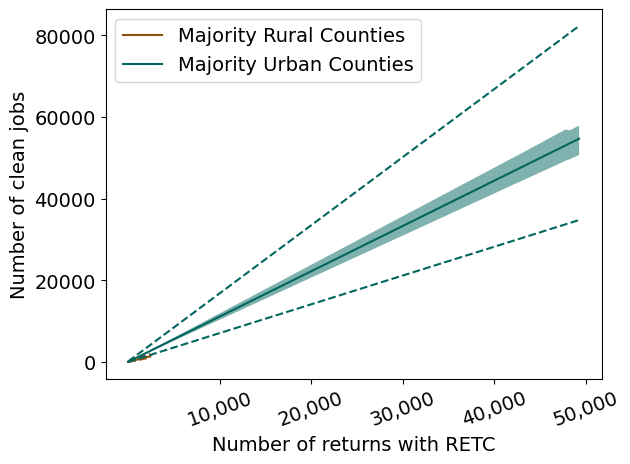

In [43]:
for ind, urban_class in enumerate(urban_classes):
    if urban_class == 0:
        plt.plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.50],
            colors4[0],
            label=f"Majority Rural Counties",
        )

        plt.plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.25],
            colors4[0],
            linestyle="dashed",
        )
        plt.plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.75],
            colors4[0],
            linestyle="dashed",
        )

        plt.fill_between(
            x_all_array[ind],
            y_pred_all_bootstrap_summary[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary[ind]["95_CI_high"],
            facecolor=colors4[0],
            alpha=0.5,
        )
    else:
        plt.plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.50],
            colors4[-1],
            label=f"Majority Urban Counties",
        )
        plt.plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.25],
            colors4[-1],
            linestyle="dashed",
        )
        plt.plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.75],
            colors4[-1],
            linestyle="dashed",
        )
        plt.fill_between(
            x_all_array[ind],
            y_pred_all_bootstrap_summary[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary[ind]["95_CI_high"],
            facecolor=colors4[-1],
            alpha=0.5,
        )

    plt.legend()
    plt.xlabel("Number of returns with RETC")
    plt.ylabel("Number of clean jobs")
    plt.xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )

plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_segmented_{JOBS_ESTIMATE}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

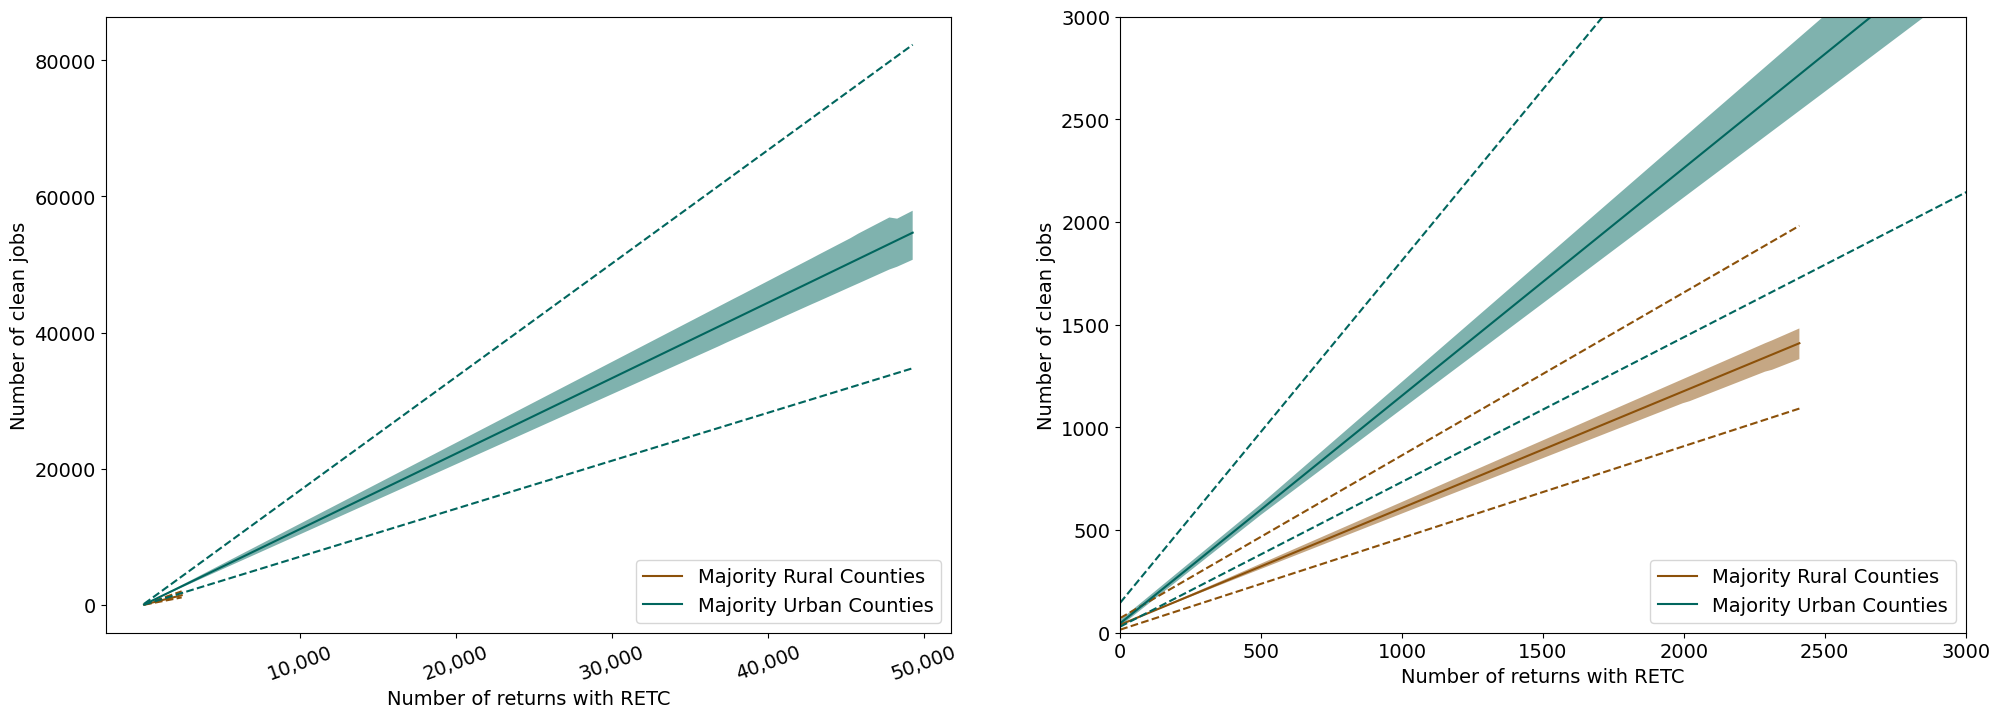

In [44]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(24, 8),
)
for ind, urban_class in enumerate(urban_classes):
    if urban_class == 0:
        axes[0].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.50],
            colors4[0],
            label=f"Majority Rural Counties",
        )

        axes[0].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.25],
            colors4[0],
            linestyle="dashed",
        )
        axes[0].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.75],
            colors4[0],
            linestyle="dashed",
        )

        axes[0].fill_between(
            x_all_array[ind],
            y_pred_all_bootstrap_summary[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary[ind]["95_CI_high"],
            facecolor=colors4[0],
            alpha=0.5,
        )
    else:
        axes[0].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.50],
            colors4[-1],
            label=f"Majority Urban Counties",
        )
        axes[0].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.25],
            colors4[-1],
            linestyle="dashed",
        )
        axes[0].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.75],
            colors4[-1],
            linestyle="dashed",
        )
        axes[0].fill_between(
            x_all_array[ind],
            y_pred_all_bootstrap_summary[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary[ind]["95_CI_high"],
            facecolor=colors4[-1],
            alpha=0.5,
        )

    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("Number of returns with RETC")
    axes[0].set_ylabel("Number of clean jobs")
    axes[0].set_xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )

for ind, urban_class in enumerate(urban_classes):
    if urban_class == 0:
        axes[1].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.50],
            colors4[0],
            label=f"Majority Rural Counties",
        )

        axes[1].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.25],
            colors4[0],
            linestyle="dashed",
        )
        axes[1].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.75],
            colors4[0],
            linestyle="dashed",
        )

        axes[1].fill_between(
            x_all_array[ind],
            y_pred_all_bootstrap_summary[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary[ind]["95_CI_high"],
            facecolor=colors4[0],
            alpha=0.5,
        )
    else:
        axes[1].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.50],
            colors4[-1],
            label=f"Majority Urban Counties",
        )
        axes[1].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.25],
            colors4[-1],
            linestyle="dashed",
        )
        axes[1].plot(
            df_p_all_urban[ind]["num_returns"],
            df_p_all_urban[ind][0.75],
            colors4[-1],
            linestyle="dashed",
        )
        axes[1].fill_between(
            x_all_array[ind],
            y_pred_all_bootstrap_summary[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary[ind]["95_CI_high"],
            facecolor=colors4[-1],
            alpha=0.5,
        )

    axes[1].legend(loc="lower right")
    axes[1].set_xlabel("Number of returns with RETC")
    axes[1].set_ylabel("Number of clean jobs")
    axes[1].set_xlim(left=0, right=3000)
    axes[1].set_ylim(bottom=0, top=3000)


plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_segmented_{JOBS_ESTIMATE}_zoomed.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

## Urban vs Rural: AGI segmentation 

In [64]:
urban_jobs_df = jobs_vs_credits_urban[
    jobs_vs_credits_urban["urban_category"] == 1
]
rural_jobs_df = jobs_vs_credits_urban[
    jobs_vs_credits_urban["urban_category"] == 0
]

In [65]:
# Urban
agi_classes = list(range(1, 6))
df_p_all_urban_agi = []
x_all_array_urban_agi = []
y_pred_all_bootstrap_summary_urban_agi = []

for ind, agi_class in enumerate(agi_classes):
    print(f"\nAGI class {agi_class}")
    if (
        len(urban_jobs_df[urban_jobs_df["agi_by_median_income"] == agi_class])
        >= 1
    ):
        df_p = run_quantile_regression(
            urban_jobs_df[urban_jobs_df["agi_by_median_income"] == agi_class],
            "num_returns",
            "clean_jobs",
            1,  # polynomials[ind], --> all linear
        )
        df_p_all_urban_agi.append(df_p)

        (
            y_pred_bootstrap_summary_urban_agi,
            x_array_urban_agi,
        ) = bootstrap_poly_quantile_regression_analysis(
            urban_jobs_df[urban_jobs_df["agi_by_median_income"] == agi_class],
            "num_returns",
            "clean_jobs",
            1,  # polynomials[ind], --> all linear
        )
        x_all_array_urban_agi.append(x_array_urban_agi)
        y_pred_all_bootstrap_summary_urban_agi.append(
            y_pred_bootstrap_summary_urban_agi
        )

    else:
        print(f"No samples in agi_class {agi_class}")


AGI class 1
No samples in agi_class 1

AGI class 2
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.3107
Model:                       QuantReg   Bandwidth:                       76.74
Method:                 Least Squares   Sparsity:                        341.2
Date:                Mon, 13 Nov 2023   No. Observations:                 1280
Time:                        17:13:54   Df Residuals:                     1278
                                        Df Model:                            1
                  coef    std err          t                 P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept      61.9867     5.0290    12.3258 4.575360380178152e-33     52.1207     71.8527
num_returns     0.6600     0.0035   189.3659                   0.0      0.6532      0.6668

The condition number is large,

In [66]:
df_p_all_urban_agi.insert(0, None)
x_all_array_urban_agi.insert(0, None)
y_pred_all_bootstrap_summary_urban_agi.insert(0, None)

In [67]:
# rural
agi_classes = list(range(1, 6))
df_p_all_rural_agi = []
x_all_array_rural_agi = []
y_pred_all_bootstrap_summary_rural_agi = []

for ind, agi_class in enumerate(agi_classes):
    print(f"\nAGI class {agi_class}")
    if (
        len(rural_jobs_df[rural_jobs_df["agi_by_median_income"] == agi_class])
        >= 1
    ):
        df_p = run_quantile_regression(
            rural_jobs_df[rural_jobs_df["agi_by_median_income"] == agi_class],
            "num_returns",
            "clean_jobs",
            1,  # polynomials[ind], --> all linear
        )
        df_p_all_rural_agi.append(df_p)

        (
            y_pred_bootstrap_summary_rural_agi,
            x_array_rural_agi,
        ) = bootstrap_poly_quantile_regression_analysis(
            rural_jobs_df[rural_jobs_df["agi_by_median_income"] == agi_class],
            "num_returns",
            "clean_jobs",
            1,  # polynomials[ind], --> all linear
        )
        x_all_array_rural_agi.append(x_array_rural_agi)
        y_pred_all_bootstrap_summary_rural_agi.append(
            y_pred_bootstrap_summary_rural_agi
        )

    else:
        print(f"No samples in agi_class {agi_class}")


AGI class 1
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:              0.03298
Model:                       QuantReg   Bandwidth:                       3.355
Method:                 Least Squares   Sparsity:                        7.164
Date:                Mon, 13 Nov 2023   No. Observations:                   45
Time:                        17:15:23   Df Residuals:                       43
                                        Df Model:                            1
                  coef    std err          t                  P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       7.0000     0.6779    10.3267 3.2246340848414705e-13      5.6330      8.3670
num_returns     0.0091     0.0150     0.6048      0.548521722105751     -0.0212      0.0394

AGI class 2
                         QuantReg Regression Results 

In [68]:
rural_agi4 = df_p_all_rural_agi[-2]
rural_agi4

,num_returns,0.25,0.5,0.75
0,0.000000,3.461539,14.000000,101.252525
1,41.224490,21.695448,43.243622,137.063698
2,82.448980,39.929357,72.487245,172.874871
3,123.673469,58.163266,101.730867,208.686044
4,164.897959,76.397174,130.974490,244.497217
5,206.122449,94.631083,160.218112,280.308390
6,247.346939,112.864992,189.461735,316.119563
7,288.571429,131.098901,218.705357,351.930736
8,329.795918,149.332810,247.948980,387.741909
9,371.020408,167.566718,277.192602,423.553082


In [69]:
rural_agi5 = df_p_all_rural_agi[-1]
rural_agi5

,num_returns,0.25,0.5,0.75
0,50.000000,58.571387,147.000000,179.404764
1,85.306122,82.997480,170.282960,210.703921
2,120.612245,107.423574,193.565920,242.003079
3,155.918367,131.849667,216.848880,273.302237
4,191.224490,156.275761,240.131840,304.601394
5,226.530612,180.701855,263.414800,335.900552
6,261.836735,205.127948,286.697760,367.199710
7,297.142857,229.554042,309.980720,398.498868
8,332.448980,253.980135,333.263680,429.798025
9,367.755102,278.406229,356.546640,461.097183


In [70]:
# for ind in range(len(rural_agi4)):
#     if rural_agi4[ind] > rural_agi5[ind]:
#         print(ind)

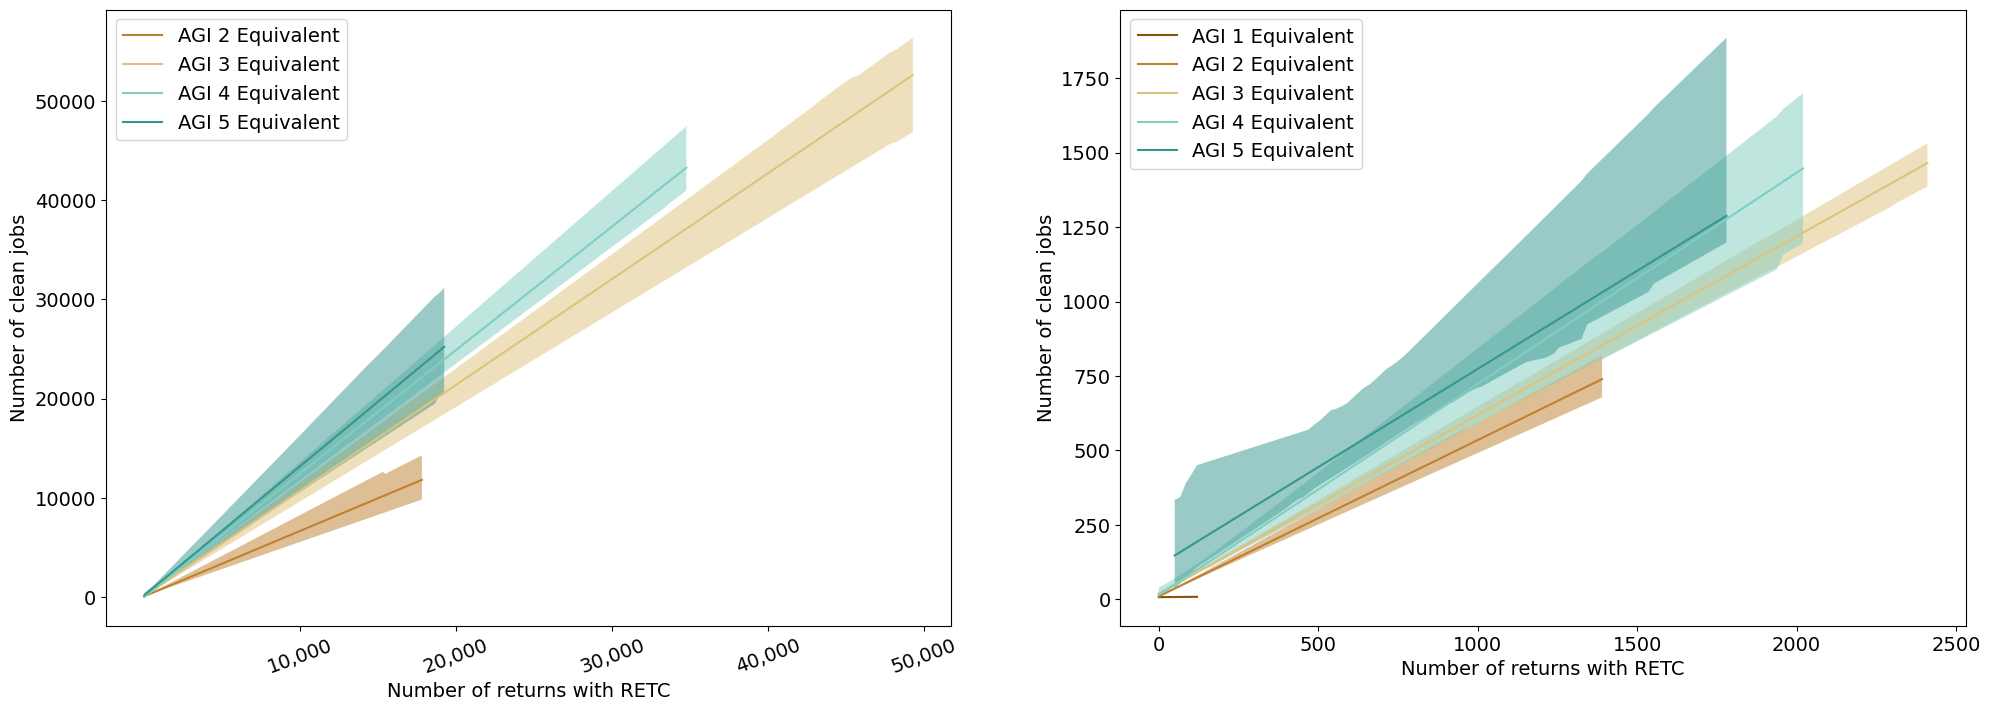

In [71]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(24, 8),
)

for ind, agi_class in enumerate(agi_classes):
    if ind > 0:
        axes[0].plot(
            df_p_all_urban_agi[ind]["num_returns"],
            df_p_all_urban_agi[ind][0.50],
            colors[ind],
            label=f"AGI {agi_class} Equivalent",
        )

        axes[0].fill_between(
            x_all_array_urban_agi[ind],
            y_pred_all_bootstrap_summary_urban_agi[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary_urban_agi[ind]["95_CI_high"],
            facecolor=colors[ind],
            alpha=0.5,
        )

        axes[0].legend()
        axes[0].set_xlabel("Number of returns with RETC")
        axes[0].set_ylabel("Number of clean jobs")
        axes[0].set_xticks(
            [10000, 20000, 30000, 40000, 50000],
            labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
            rotation=20,
        )

    ##############################################################
    axes[1].plot(
        df_p_all_rural_agi[ind]["num_returns"],
        df_p_all_rural_agi[ind][0.50],
        colors[ind],
        label=f"AGI {agi_class} Equivalent",
    )

    axes[1].fill_between(
        x_all_array_rural_agi[ind],
        y_pred_all_bootstrap_summary_rural_agi[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_agi[ind]["95_CI_high"],
        facecolor=colors[ind],
        alpha=0.5,
    )

    axes[1].legend()
    axes[1].set_xlabel("Number of returns with RETC")
    axes[1].set_ylabel("Number of clean jobs")
#     axes[1].set_xticks(
#         [10000, 20000, 30000, 40000, 50000],
#         labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
#         rotation=20,
#     )

plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_agi_segmented_{JOBS_ESTIMATE}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

## Urban vs Rural: Homeownership segmentation

In [72]:
# Urban
df_p_all_urban_homeowners = []
x_all_array_urban_homeowners = []
y_pred_all_bootstrap_summary_urban_homeowners = []

oo_classes = list(range(0, 4))
for ind, oo_class in enumerate(oo_classes):
    df = urban_jobs_df[
        urban_jobs_df["percent_owner_occupied_quartiles"] == oo_class
    ]
    cutoff = np.max(df["percent_owner_occupied"].values)
    print(f"Cutoff for quartile {ind} =  {cutoff}")
    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    df_p_all_urban_homeowners.append(df_p)

    (
        y_pred_bootstrap_summary_urban_homeowners,
        x_array_urban_homeowners,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array_urban_homeowners.append(x_array_urban_homeowners)
    y_pred_all_bootstrap_summary_urban_homeowners.append(
        y_pred_bootstrap_summary_urban_homeowners
    )
    print("\n")

Cutoff for quartile 0 =  0.6780111272617914
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.4474
Model:                       QuantReg   Bandwidth:                       179.4
Method:                 Least Squares   Sparsity:                        812.3
Date:                Mon, 13 Nov 2023   No. Observations:                 2750
Time:                        17:17:07   Df Residuals:                     2748
                                        Df Model:                            1
                  coef    std err          t                  P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept      41.0001     8.4753     4.8376 1.3868291628552645e-06     24.3815     57.6188
num_returns     1.2845     0.0018   704.2633                    0.0      1.2809      1.2881

The condition number is large, 5.0

In [73]:
# rural
df_p_all_rural_homeowners = []
x_all_array_rural_homeowners = []
y_pred_all_bootstrap_summary_rural_homeowners = []

oo_classes = list(range(0, 4))
for ind, oo_class in enumerate(oo_classes):
    df = rural_jobs_df[
        rural_jobs_df["percent_owner_occupied_quartiles"] == oo_class
    ]
    cutoff = np.max(df["percent_owner_occupied"].values)
    print(f"Cutoff for quartile {ind} =  {cutoff}")
    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    df_p_all_rural_homeowners.append(df_p)

    (
        y_pred_bootstrap_summary_rural_homeowners,
        x_array_rural_homeowners,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array_rural_homeowners.append(x_array_rural_homeowners)
    y_pred_all_bootstrap_summary_rural_homeowners.append(
        y_pred_bootstrap_summary_rural_homeowners
    )
    print("\n")

Cutoff for quartile 0 =  0.6779661016949152
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.2429
Model:                       QuantReg   Bandwidth:                       16.64
Method:                 Least Squares   Sparsity:                        62.17
Date:                Mon, 13 Nov 2023   No. Observations:                 1174
Time:                        17:18:34   Df Residuals:                     1172
                                        Df Model:                            1
                  coef    std err          t                 P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept       8.0000     1.0633     7.5235 1.058793902524877e-13      5.9137     10.0863
num_returns     0.6143     0.0070    87.9929                   0.0      0.6006      0.6280


Cutoff for quartile 1 =  0.7316982534

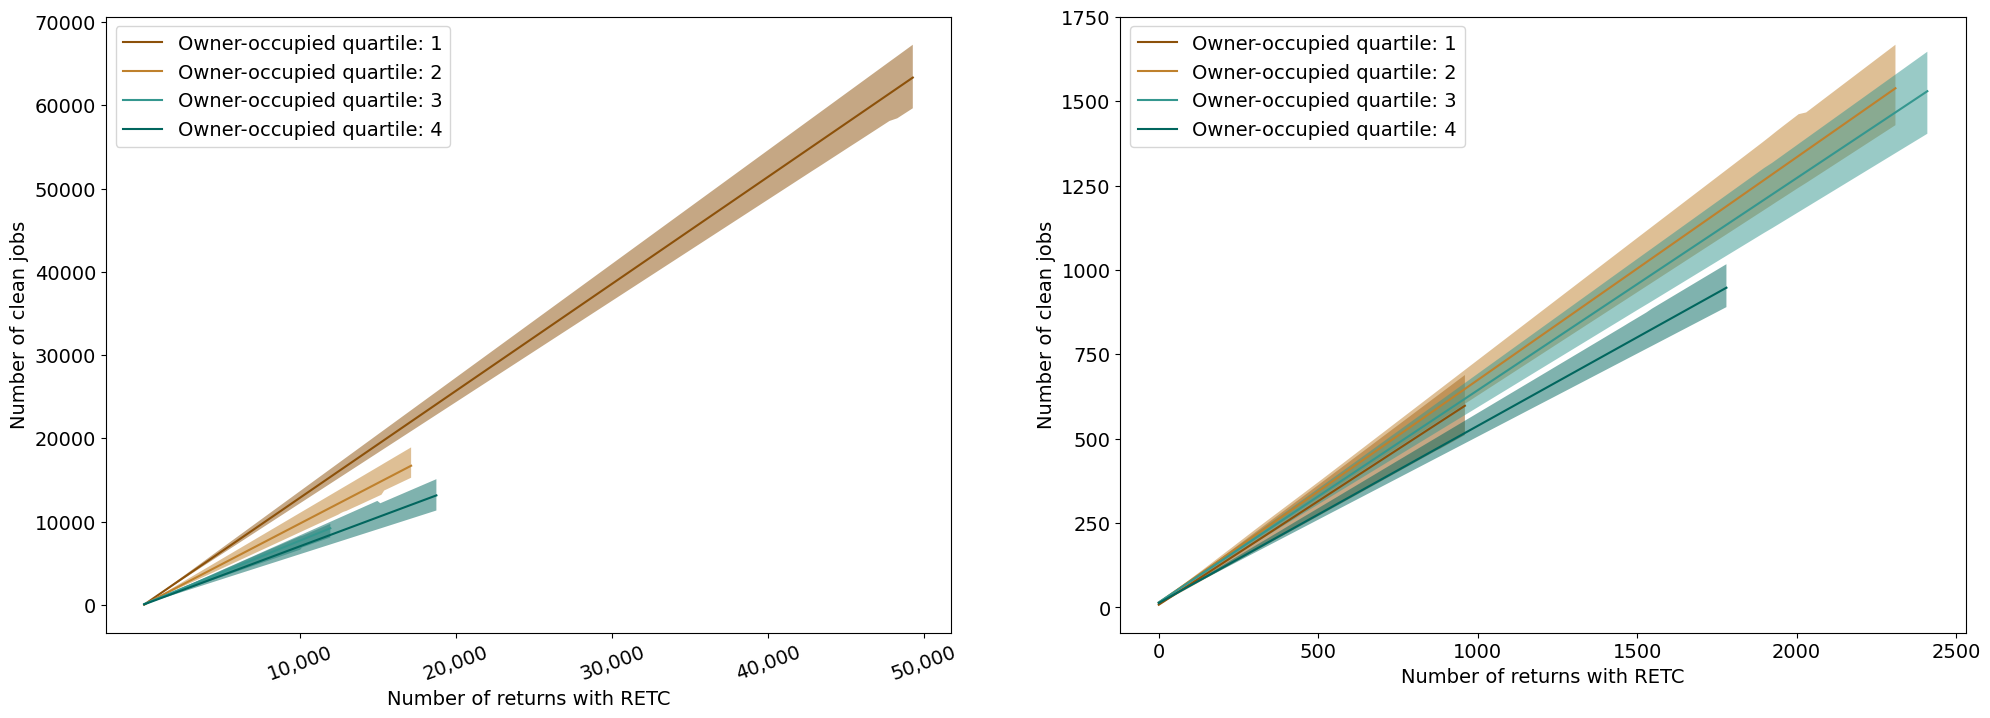

In [74]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(24, 8),
)

for ind, oo_class in enumerate(oo_classes):
    axes[0].plot(
        df_p_all_urban_homeowners[ind]["num_returns"],
        df_p_all_urban_homeowners[ind][0.50],
        colors4[ind],
        label=f"Owner-occupied quartile: {oo_class+1}",
    )

    axes[0].fill_between(
        x_all_array_urban_homeowners[ind],
        y_pred_all_bootstrap_summary_urban_homeowners[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_urban_homeowners[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[0].legend()
    axes[0].set_xlabel("Number of returns with RETC")
    axes[0].set_ylabel("Number of clean jobs")
    axes[0].set_xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )

    ##############################################################
    axes[1].plot(
        df_p_all_rural_homeowners[ind]["num_returns"],
        df_p_all_rural_homeowners[ind][0.50],
        colors4[ind],
        label=f"Owner-occupied quartile: {oo_class+1}",
    )

    axes[1].fill_between(
        x_all_array_rural_homeowners[ind],
        y_pred_all_bootstrap_summary_rural_homeowners[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_homeowners[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[1].legend()
    axes[1].set_xlabel("Number of returns with RETC")
    axes[1].set_ylabel("Number of clean jobs")


plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_homeowners_segmented_{JOBS_ESTIMATE}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

## Urban vs Rural: Race segmented

In [75]:
# Urban
df_p_all_urban_race = []
x_all_array_urban_race = []
y_pred_all_bootstrap_summary_urban_race = []

race_classes = list(range(0, 4))
for ind, race_class in enumerate(race_classes):
    df = urban_jobs_df[
        urban_jobs_df["percent_white_alone_quartiles"] == race_class
    ]
    cutoff = np.max(df["percent_white_alone"].values)
    print(f"Cutoff for quartile {ind} =  {cutoff}")
    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    df_p_all_urban_race.append(df_p)

    (
        y_pred_bootstrap_summary_urban_race,
        x_array_urban_race,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array_urban_race.append(x_array_urban_race)
    y_pred_all_bootstrap_summary_urban_race.append(
        y_pred_bootstrap_summary_urban_race
    )
    print("\n")

Cutoff for quartile 0 =  0.6991431291653444
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.4373
Model:                       QuantReg   Bandwidth:                       229.8
Method:                 Least Squares   Sparsity:                        911.0
Date:                Mon, 13 Nov 2023   No. Observations:                 1880
Time:                        17:20:04   Df Residuals:                     1878
                                        Df Model:                            1
                  coef    std err          t              P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept      -3.9091    11.7373    -0.3330 0.7391355914105224    -26.9287     19.1105
num_returns     1.2273     0.0021   581.1180                0.0      1.2231      1.2314

The condition number is large, 6.21e+03. This migh

In [76]:
# rural
df_p_all_rural_race = []
x_all_array_rural_race = []
y_pred_all_bootstrap_summary_rural_race = []

race_classes = list(range(0, 4))
for ind, race_class in enumerate(race_classes):
    df = rural_jobs_df[
        rural_jobs_df["percent_white_alone_quartiles"] == race_class
    ]
    cutoff = np.max(df["percent_white_alone"].values)
    print(f"Cutoff for quartile {ind} =  {cutoff}")
    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    df_p_all_rural_race.append(df_p)

    (
        y_pred_bootstrap_summary_rural_race,
        x_array_rural_race,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array_rural_race.append(x_array_rural_race)
    y_pred_all_bootstrap_summary_rural_race.append(
        y_pred_bootstrap_summary_rural_race
    )
    print("\n")

Cutoff for quartile 0 =  0.6995336442371752
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.2296
Model:                       QuantReg   Bandwidth:                       14.08
Method:                 Least Squares   Sparsity:                        64.06
Date:                Mon, 13 Nov 2023   No. Observations:                 2044
Time:                        17:21:35   Df Residuals:                     2042
                                        Df Model:                            1
                  coef    std err          t                 P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept       8.0000     0.8473     9.4416 9.650946195961975e-21      6.3383      9.6617
num_returns     0.4714     0.0049    97.1033                   0.0      0.4619      0.4810


Cutoff for quartile 1 =  0.8713718862

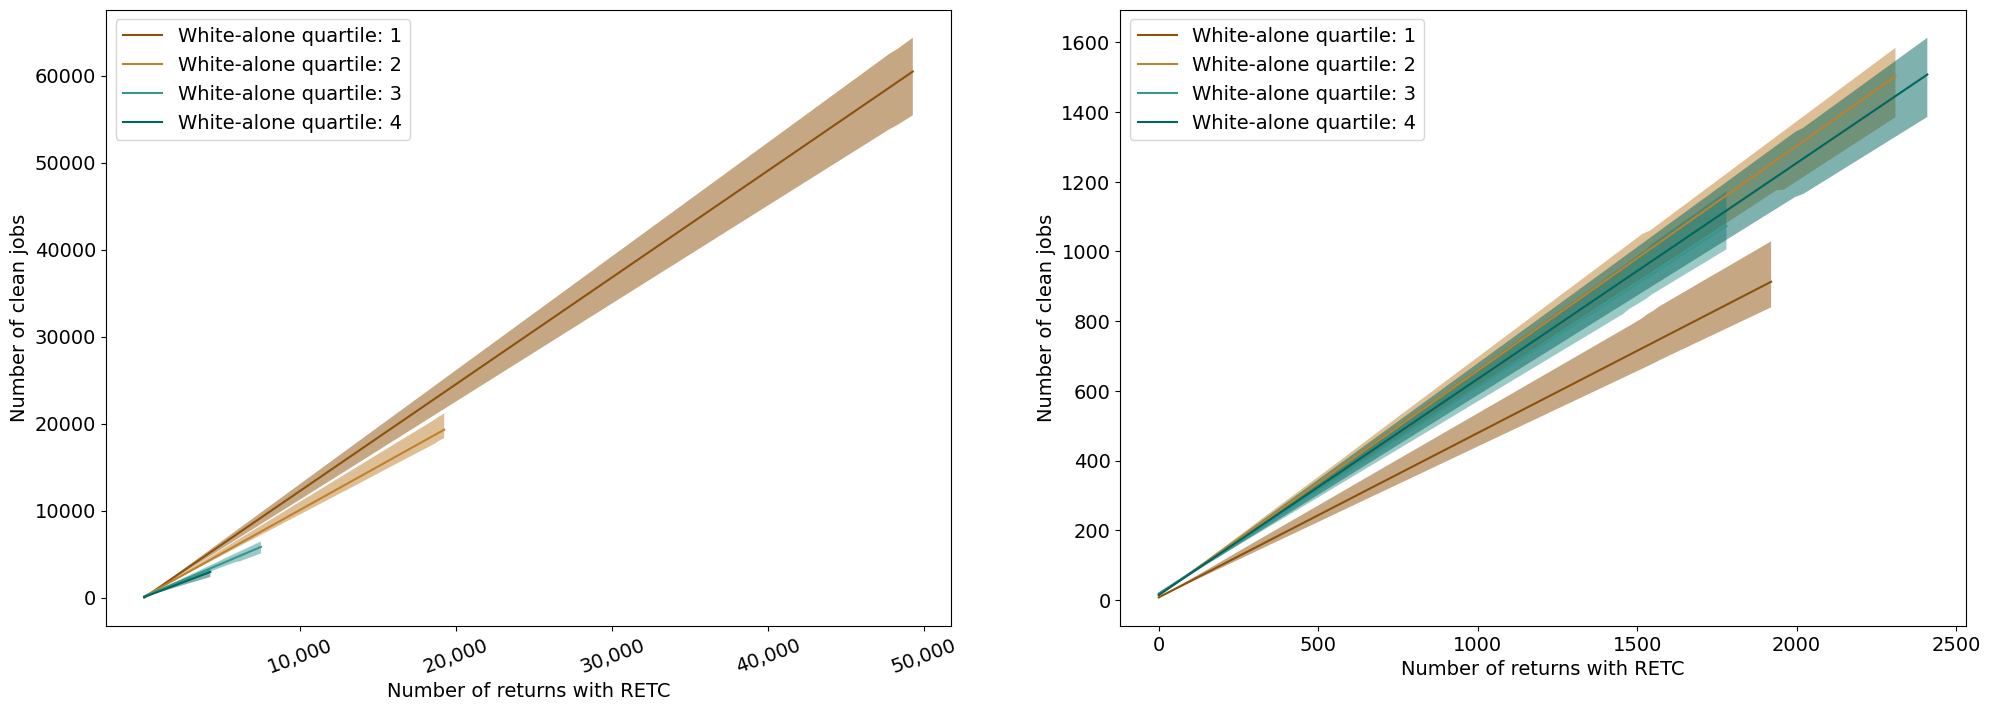

In [77]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(24, 8),
)

for ind, oo_class in enumerate(oo_classes):
    axes[0].plot(
        df_p_all_urban_race[ind]["num_returns"],
        df_p_all_urban_race[ind][0.50],
        colors4[ind],
        label=f"White-alone quartile: {oo_class+1}",
    )

    axes[0].fill_between(
        x_all_array_urban_race[ind],
        y_pred_all_bootstrap_summary_urban_race[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_urban_race[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[0].legend()
    axes[0].set_xlabel("Number of returns with RETC")
    axes[0].set_ylabel("Number of clean jobs")
    axes[0].set_xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )

    ##############################################################
    axes[1].plot(
        df_p_all_rural_race[ind]["num_returns"],
        df_p_all_rural_race[ind][0.50],
        colors4[ind],
        label=f"White-alone quartile: {oo_class+1}",
    )

    axes[1].fill_between(
        x_all_array_rural_race[ind],
        y_pred_all_bootstrap_summary_rural_race[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_race[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[1].legend()
    axes[1].set_xlabel("Number of returns with RETC")
    axes[1].set_ylabel("Number of clean jobs")


plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_race_segmented_{JOBS_ESTIMATE}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

## Median income quartiles

In [78]:
# Urban
df_p_all_urban_income_quartiles = []
x_all_array_urban_income_quartiles = []
y_pred_all_bootstrap_summary_urban_income_quartiles = []

oo_classes = list(range(0, 4))
for ind, oo_class in enumerate(oo_classes):
    df = urban_jobs_df[urban_jobs_df["median_income_quartiles"] == oo_class]
    cutoff = np.max(df["percent_owner_occupied"].values)
    print(f"Cutoff for quartile {ind} =  {cutoff}")
    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    df_p_all_urban_income_quartiles.append(df_p)

    (
        y_pred_bootstrap_summary_urban_income_quartiles,
        x_array_urban_income_quartiles,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array_urban_income_quartiles.append(x_array_urban_income_quartiles)
    y_pred_all_bootstrap_summary_urban_income_quartiles.append(
        y_pred_bootstrap_summary_urban_income_quartiles
    )
    print("\n")

Cutoff for quartile 0 =  0.8119057461761058
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.1698
Model:                       QuantReg   Bandwidth:                       73.56
Method:                 Least Squares   Sparsity:                        321.7
Date:                Mon, 13 Nov 2023   No. Observations:                  615
Time:                        17:23:05   Df Residuals:                      613
                                        Df Model:                            1
                  coef    std err          t                  P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept      80.4467     6.7668    11.8884 1.7872202812288312e-29     67.1577     93.7357
num_returns     0.2713     0.0060    45.0953 7.382948804219123e-197      0.2595      0.2831

The condition number is large, 1.1

In [79]:
# rural
df_p_all_rural_income_quartiles = []
x_all_array_rural_income_quartiles = []
y_pred_all_bootstrap_summary_rural_income_quartiles = []

oo_classes = list(range(0, 4))
for ind, oo_class in enumerate(oo_classes):
    df = rural_jobs_df[rural_jobs_df["median_income_quartiles"] == oo_class]
    cutoff = np.max(df["percent_owner_occupied"].values)
    print(f"Cutoff for quartile {ind} =  {cutoff}")
    df_p = run_quantile_regression(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    df_p_all_rural_income_quartiles.append(df_p)

    (
        y_pred_bootstrap_summary_rural_income_quartiles,
        x_array_rural_income_quartiles,
    ) = bootstrap_poly_quantile_regression_analysis(
        df,
        "num_returns",
        "clean_jobs",
        1,  # polynomials[ind], --> all linear
    )
    x_all_array_rural_income_quartiles.append(x_array_rural_income_quartiles)
    y_pred_all_bootstrap_summary_rural_income_quartiles.append(
        y_pred_bootstrap_summary_rural_income_quartiles
    )
    print("\n")

Cutoff for quartile 0 =  0.964200477326969
                         QuantReg Regression Results                          
Dep. Variable:             clean_jobs   Pseudo R-squared:               0.1706
Model:                       QuantReg   Bandwidth:                       11.97
Method:                 Least Squares   Sparsity:                        56.50
Date:                Mon, 13 Nov 2023   No. Observations:                 3309
Time:                        17:24:31   Df Residuals:                     3307
                                        Df Model:                            1
                  coef    std err          t                  P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       8.0000     0.5929    13.4928 1.9852326725479906e-40      6.8375      9.1625
num_returns     0.4867     0.0049    99.8792                    0.0      0.4771      0.4962


Cutoff for quartile 1 =  0.9100266

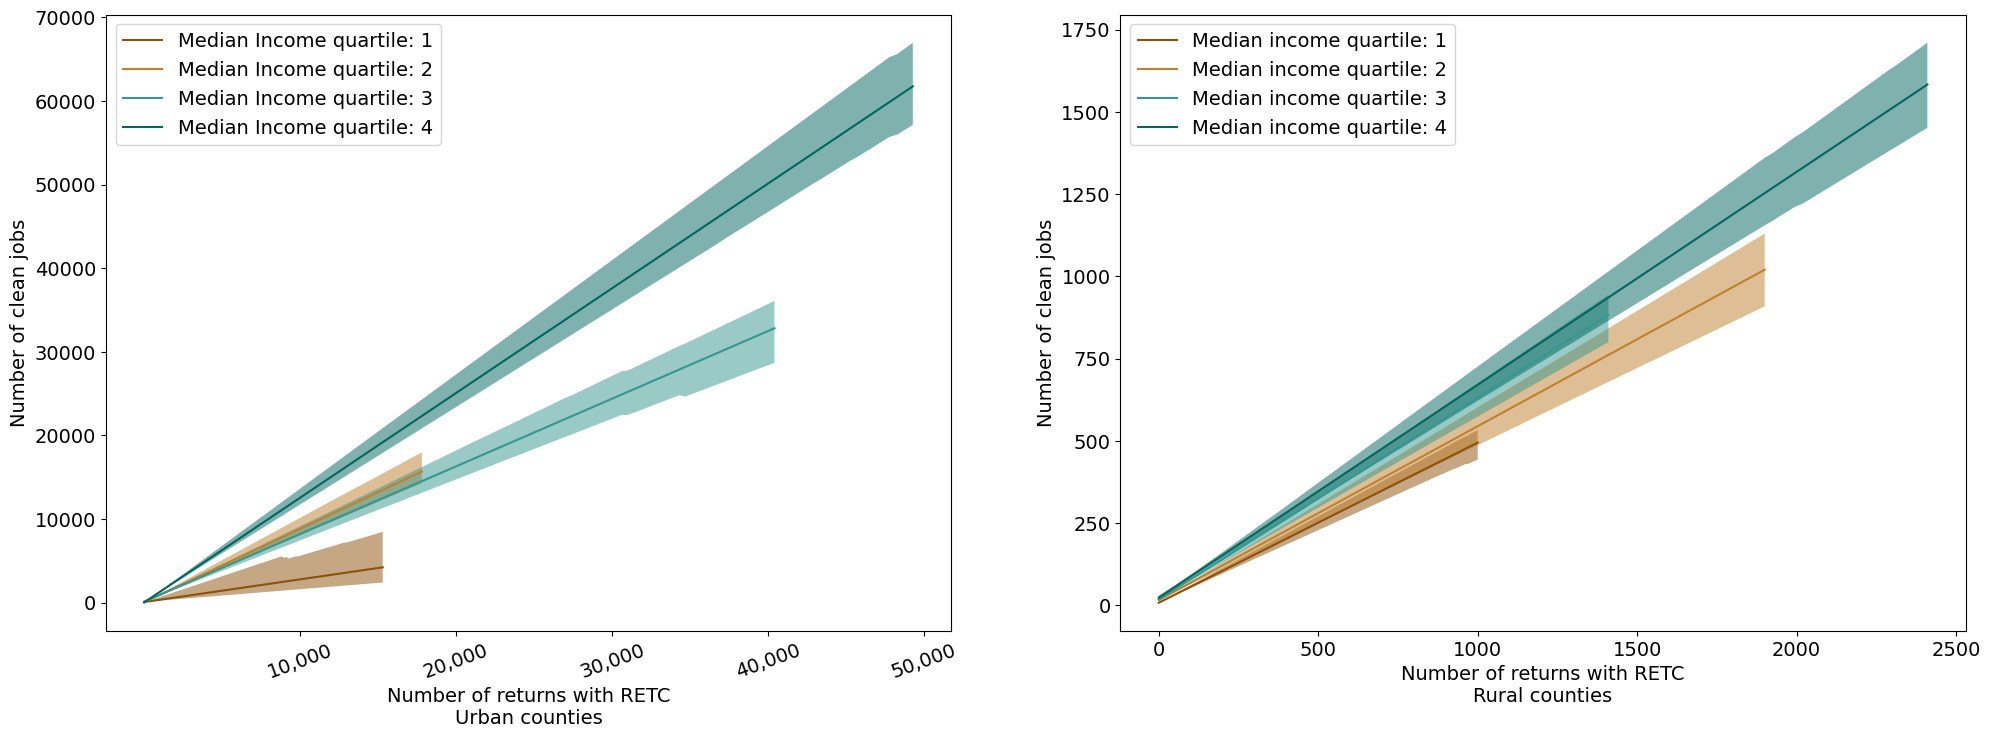

In [80]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(24, 8),
)

for ind, oo_class in enumerate(oo_classes):
    axes[0].plot(
        df_p_all_urban_income_quartiles[ind]["num_returns"],
        df_p_all_urban_income_quartiles[ind][0.50],
        colors4[ind],
        label=f"Median Income quartile: {oo_class+1}",
    )

    axes[0].fill_between(
        x_all_array_urban_income_quartiles[ind],
        y_pred_all_bootstrap_summary_urban_income_quartiles[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_urban_income_quartiles[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[0].legend()
    axes[0].set_xlabel("Number of returns with RETC\nUrban counties")
    axes[0].set_ylabel("Number of clean jobs")
    axes[0].set_xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )

    ##############################################################
    axes[1].plot(
        df_p_all_rural_income_quartiles[ind]["num_returns"],
        df_p_all_rural_income_quartiles[ind][0.50],
        colors4[ind],
        label=f"Median income quartile: {oo_class+1}",
    )

    axes[1].fill_between(
        x_all_array_rural_income_quartiles[ind],
        y_pred_all_bootstrap_summary_rural_income_quartiles[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_income_quartiles[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[1].legend()
    axes[1].set_xlabel("Number of returns with RETC\nRural counties")
    axes[1].set_ylabel("Number of clean jobs")


plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_income_quartiles_segmented_{JOBS_ESTIMATE}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

### One big plot with subplots

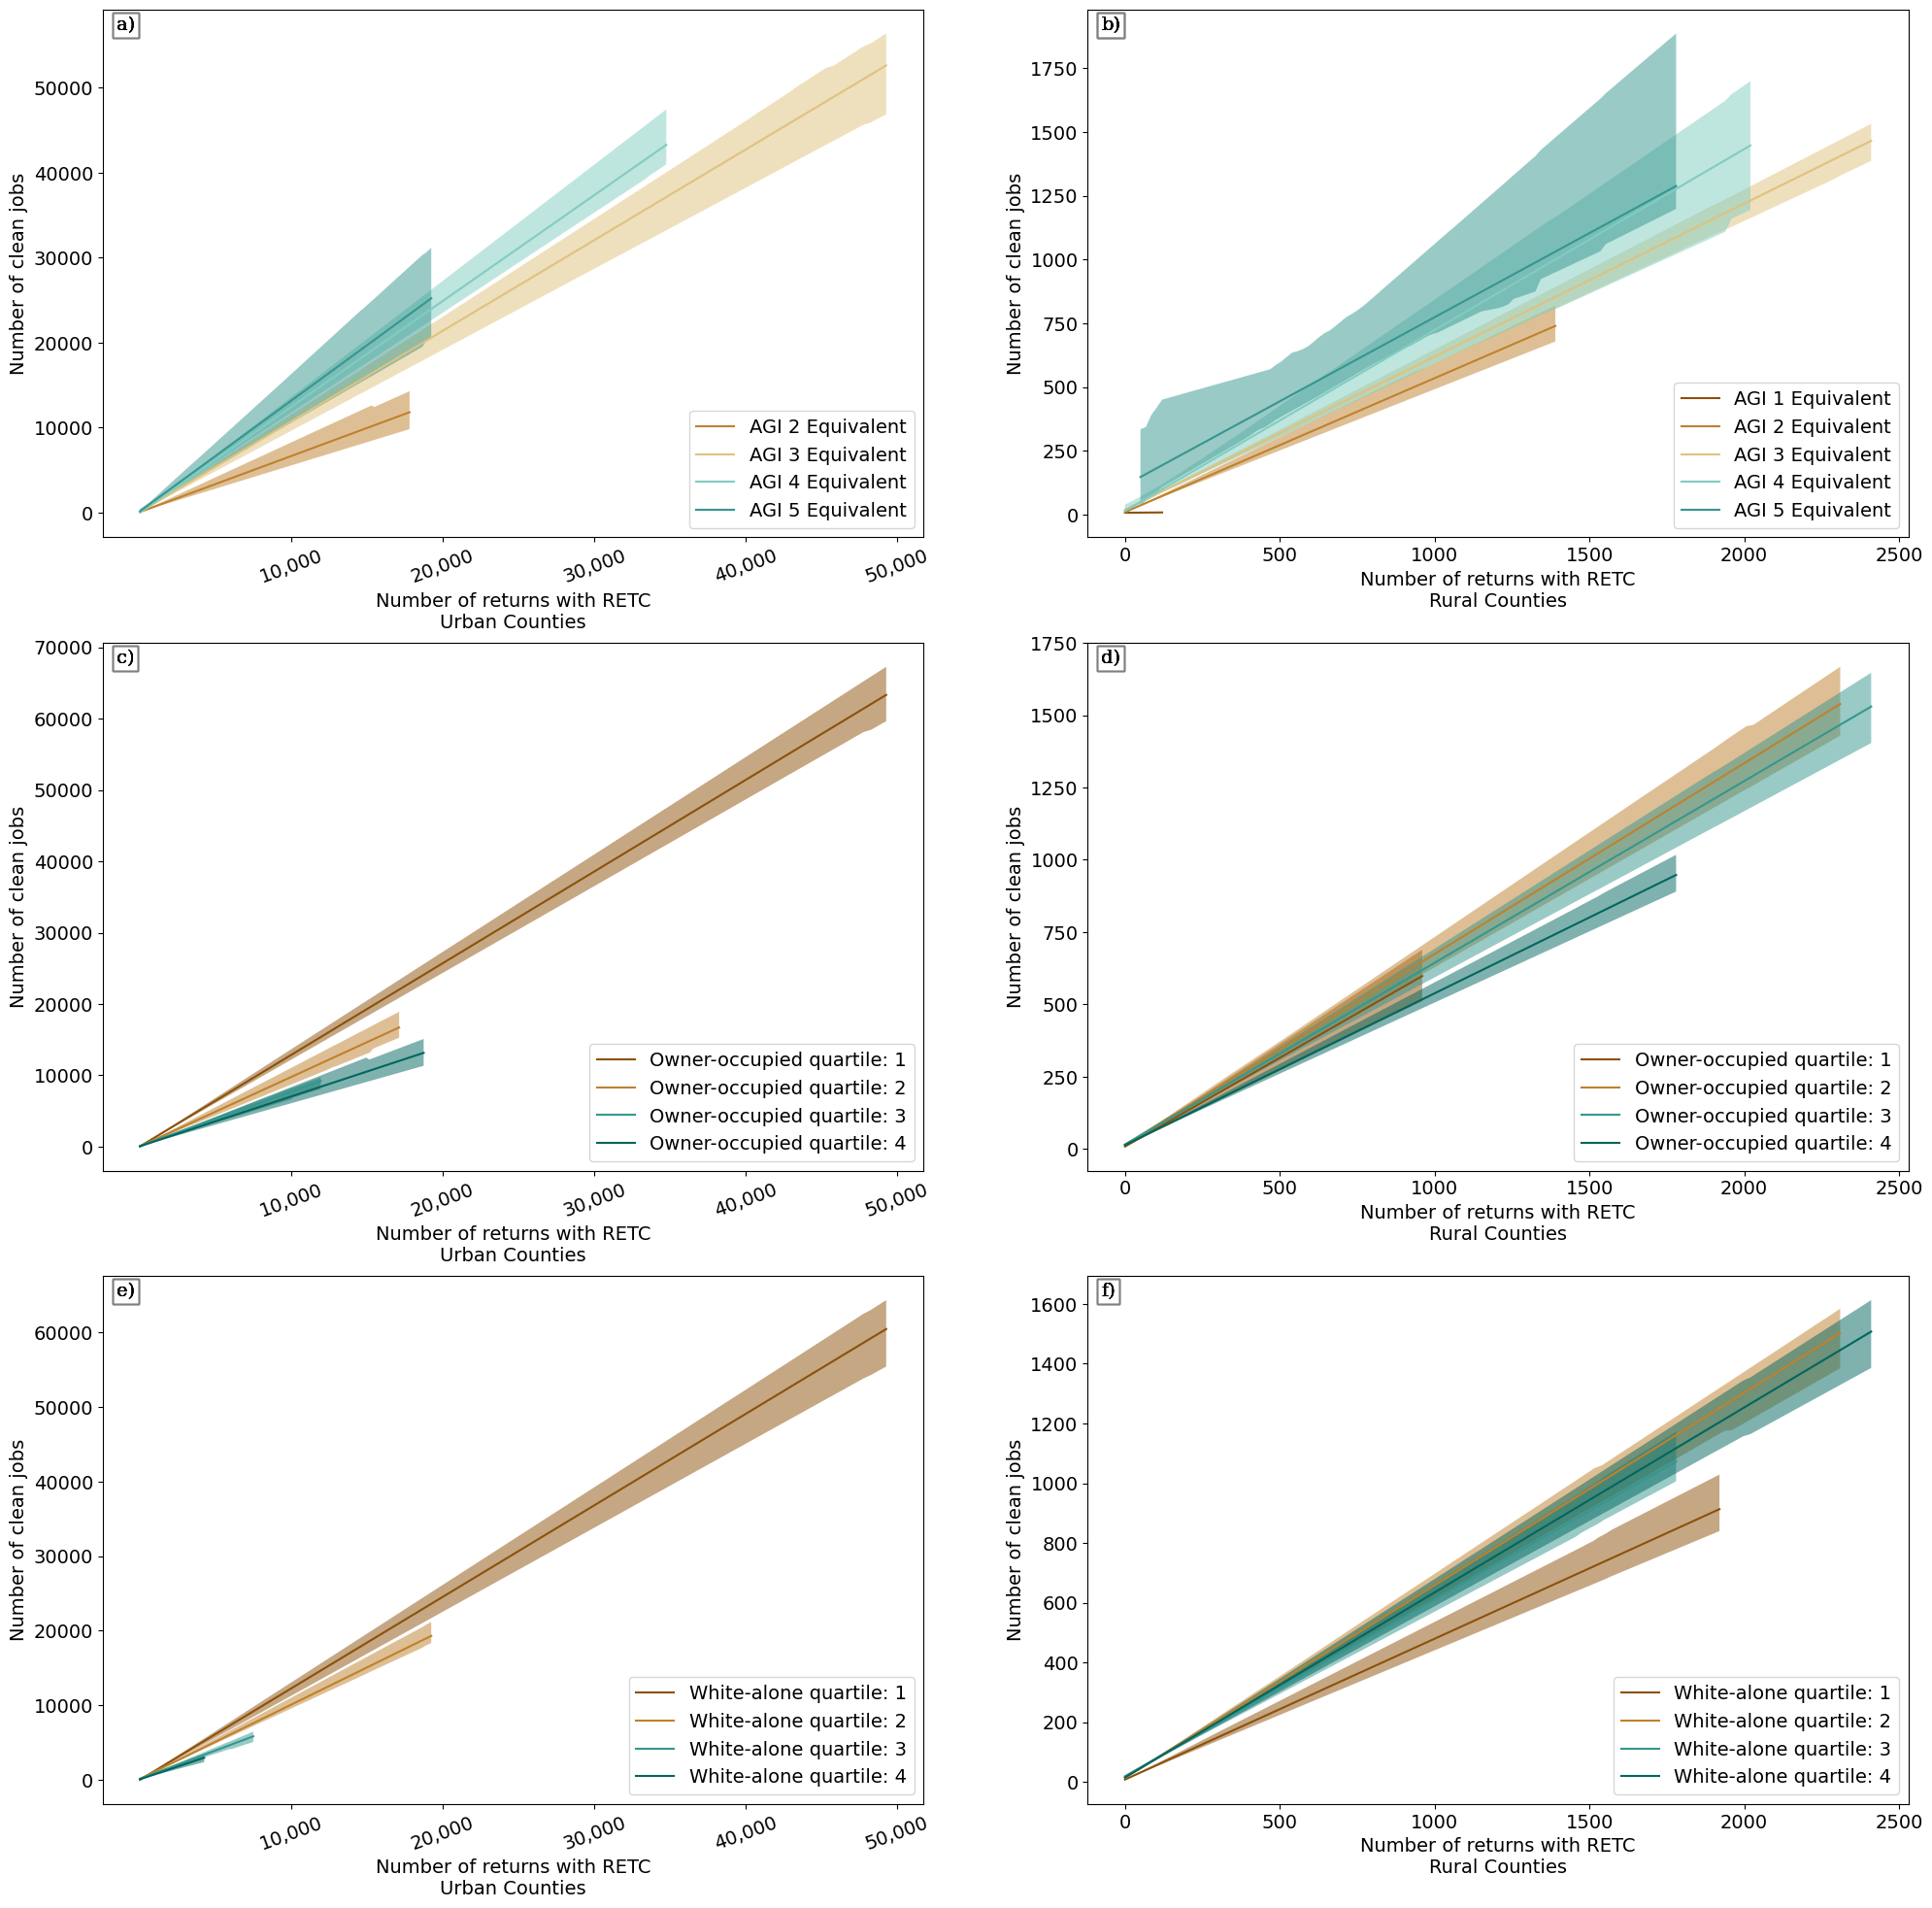

In [81]:
import matplotlib.transforms as mtransforms

subplot_labels = ["a)", "b)", "c)", "d)", "e)", "f)"]
trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)


fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(24, 24),
)

for ind, agi_class in enumerate(agi_classes):
    if ind > 0:
        axes[0][0].plot(
            df_p_all_urban_agi[ind]["num_returns"],
            df_p_all_urban_agi[ind][0.50],
            colors[ind],
            label=f"AGI {agi_class} Equivalent",
        )

        axes[0][0].fill_between(
            x_all_array_urban_agi[ind],
            y_pred_all_bootstrap_summary_urban_agi[ind]["95_CI_low"],
            y_pred_all_bootstrap_summary_urban_agi[ind]["95_CI_high"],
            facecolor=colors[ind],
            alpha=0.5,
        )

        axes[0][0].legend(loc="lower right")
        axes[0][0].set_xlabel("Number of returns with RETC\nUrban Counties")
        axes[0][0].set_ylabel("Number of clean jobs")
        axes[0][0].set_xticks(
            [10000, 20000, 30000, 40000, 50000],
            labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
            rotation=20,
        )
        axes[0][0].text(
            0.0,
            1.0,
            subplot_labels[0],
            transform=axes[0][0].transAxes + trans,
            fontsize="medium",
            verticalalignment="top",
            fontfamily="serif",
            bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
        )

    ##############################################################
    axes[0][1].plot(
        df_p_all_rural_agi[ind]["num_returns"],
        df_p_all_rural_agi[ind][0.50],
        colors[ind],
        label=f"AGI {agi_class} Equivalent",
    )

    axes[0][1].fill_between(
        x_all_array_rural_agi[ind],
        y_pred_all_bootstrap_summary_rural_agi[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_agi[ind]["95_CI_high"],
        facecolor=colors[ind],
        alpha=0.5,
    )

    axes[0][1].legend(loc="lower right")
    axes[0][1].set_xlabel("Number of returns with RETC\nRural Counties")
    axes[0][1].set_ylabel("Number of clean jobs")
    axes[0][1].text(
        0.0,
        1.0,
        subplot_labels[1],
        transform=axes[0][1].transAxes + trans,
        fontsize="medium",
        verticalalignment="top",
        fontfamily="serif",
        bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
    )

##############################################################

for ind, oo_class in enumerate(oo_classes):
    axes[1][0].plot(
        df_p_all_urban_homeowners[ind]["num_returns"],
        df_p_all_urban_homeowners[ind][0.50],
        colors4[ind],
        label=f"Owner-occupied quartile: {oo_class+1}",
    )

    axes[1][0].fill_between(
        x_all_array_urban_homeowners[ind],
        y_pred_all_bootstrap_summary_urban_homeowners[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_urban_homeowners[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[1][0].legend(loc="lower right")
    axes[1][0].set_xlabel("Number of returns with RETC\nUrban Counties")
    axes[1][0].set_ylabel("Number of clean jobs")
    axes[1][0].set_xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )
    axes[1][0].text(
        0.0,
        1.0,
        subplot_labels[2],
        transform=axes[1][0].transAxes + trans,
        fontsize="medium",
        verticalalignment="top",
        fontfamily="serif",
        bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
    )

    ##############################################################
    axes[1][1].plot(
        df_p_all_rural_homeowners[ind]["num_returns"],
        df_p_all_rural_homeowners[ind][0.50],
        colors4[ind],
        label=f"Owner-occupied quartile: {oo_class+1}",
    )

    axes[1][1].fill_between(
        x_all_array_rural_homeowners[ind],
        y_pred_all_bootstrap_summary_rural_homeowners[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_homeowners[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[1][1].legend(loc="lower right")
    axes[1][1].set_xlabel("Number of returns with RETC\nRural Counties")
    axes[1][1].set_ylabel("Number of clean jobs")
    axes[1][1].text(
        0.0,
        1.0,
        subplot_labels[3],
        transform=axes[1][1].transAxes + trans,
        fontsize="medium",
        verticalalignment="top",
        fontfamily="serif",
        bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
    )

##############################################################

for ind, race_class in enumerate(race_classes):
    axes[2][0].plot(
        df_p_all_urban_race[ind]["num_returns"],
        df_p_all_urban_race[ind][0.50],
        colors4[ind],
        label=f"White-alone quartile: {race_class+1}",
    )

    axes[2][0].fill_between(
        x_all_array_urban_race[ind],
        y_pred_all_bootstrap_summary_urban_race[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_urban_race[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[2][0].legend(loc="lower right")
    axes[2][0].set_xlabel("Number of returns with RETC\nUrban Counties")
    axes[2][0].set_ylabel("Number of clean jobs")
    axes[2][0].set_xticks(
        [10000, 20000, 30000, 40000, 50000],
        labels=["10,000", "20,000", "30,000", "40,000", "50,000"],
        rotation=20,
    )
    axes[2][0].text(
        0.0,
        1.0,
        subplot_labels[4],
        transform=axes[2][0].transAxes + trans,
        fontsize="medium",
        verticalalignment="top",
        fontfamily="serif",
        bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
    )

    ##############################################################
    axes[2][1].plot(
        df_p_all_rural_race[ind]["num_returns"],
        df_p_all_rural_race[ind][0.50],
        colors4[ind],
        label=f"White-alone quartile: {race_class+1}",
    )

    axes[2][1].fill_between(
        x_all_array_rural_race[ind],
        y_pred_all_bootstrap_summary_rural_race[ind]["95_CI_low"],
        y_pred_all_bootstrap_summary_rural_race[ind]["95_CI_high"],
        facecolor=colors4[ind],
        alpha=0.5,
    )

    axes[2][1].legend(loc="lower right")
    axes[2][1].set_xlabel("Number of returns with RETC\nRural Counties")
    axes[2][1].set_ylabel("Number of clean jobs")
    axes[2][1].text(
        0.0,
        1.0,
        subplot_labels[5],
        transform=axes[2][1].transAxes + trans,
        fontsize="medium",
        verticalalignment="top",
        fontfamily="serif",
        bbox=dict(facecolor="none", edgecolor="gray", pad=3.0),
    )


plt.savefig(
    os.path.join(
        FIGURES_DIR,
        f"quantile_regression_jobs_urban_rural_subplots_{JOBS_ESTIMATE}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.show()